# Seattle Airbnb Data Analysis

In this notebook, I will analyze the [Seattle Airbnb dataset](https://www.kaggle.com/datasets/airbnb/seattle/data) from Kaggle. 

This project will follow and [CRoss Industry Standard Process for Data Mining - CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) which is consisted of the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modeling
5. Result Evaluation
6. Deployment

# 1. Business Understanding

Description

- Q1. 
- Q2. 
- Q3.

# 2. Data Understanding

## 2.1 Import libraries

In [1]:
import string
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

warnings.simplefilter(action='ignore', category=FutureWarning)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/mafda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mafda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mafda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
def read_dataset(csv_file):
    df = pd.read_csv(csv_file)
    print("Number of rows and columns: ", df.shape)
    return df


def get_null_col(df):
    pd.set_option("display.precision", 2)
    null_col = df.columns[df.isna().sum() > 0]
    col_null_val = df[null_col].isna().sum().sort_values(ascending=False)
    per_null_val = (df[null_col].isna().sum() / df.shape[0] * 100).sort_values(
        ascending=False
    )

    if len(col_null_val) > 0:
        nulls_df = pd.DataFrame(col_null_val, columns=["No. Nulls"])
        nulls_df["Nulls [%]"] = per_null_val
        print("Number of columns with missing data:", nulls_df.shape[0])
        return nulls_df
    else:
        print("No missing data")


def drop_cols(df):
    # Identify columns with more than 50% null values
    null_percentage = df.isnull().mean() * 100
    columns_to_drop = null_percentage[null_percentage > 50].index
    print("Columns with more than 50% null values:", len(columns_to_drop))

    if len(columns_to_drop) > 0:
        df = df.drop(columns=columns_to_drop, axis=1)
        print("Drop columns:", columns_to_drop)

    # Identify columns with a single value
    unique_value_columns = [
        col for col in df.columns if df[col].nunique() == 1
    ]
    print("Columns with a unique value:", len(unique_value_columns))

    if len(unique_value_columns) > 0:
        df = df.drop(columns=unique_value_columns, axis=1)
        print("Drop columns:", unique_value_columns)

    # Drop duplicate column
    duplicated_columns = set()
    for i in range(len(df.columns)):
        col1 = df.columns[i]
        for j in range(i + 1, len(df.columns)):
            col2 = df.columns[j]
            if df[col1].equals(df[col2]):
                duplicated_columns.add(col2)
    print("Duplicate column:", len(duplicated_columns))

    if len(duplicated_columns) > 0:
        df = df.drop(columns=duplicated_columns, axis=1)

    print("df cleaned:", df.shape)

    return df


def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    text = " ".join([word for word in words if word not in stop_words])
    return text


def get_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    return scores["compound"]


def feeling_comments(df, feeling, samples):
    print(f"Random comments with {feeling} sentiment:")
    sample_comments = (
        df.loc[df["sentiment_category_vader"] == feeling, ["comments"]]
        .sample(samples)
        .values
    )
    for comment in sample_comments:
        print("* " + comment[0])


## 2.2 Load datasets

In [3]:
df_calendar = read_dataset('../data/calendar.csv')

Number of rows and columns:  (1393570, 4)


In [4]:
df_listings = read_dataset('../data/listings.csv')

Number of rows and columns:  (3818, 92)


In [5]:
df_reviews = read_dataset('../data/reviews.csv')

Number of rows and columns:  (84849, 6)


## 2.3 Explore datasets

### Calendar Dataset

In [6]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
get_null_col(df_calendar)

Number of columns with missing data: 1


,No. Nulls,Nulls [%]
price,459028,32.94


In [8]:
# Clear and convert 'price' column
df_calendar["price"] = (
    df_calendar["price"]
    .str.replace("$", "")
    .str.replace(",", "")
    .astype(float)
)
df_calendar["price"] = df_calendar["price"].fillna(
    df_calendar["price"].median()
)

# Convert the available column to 1 or 0
df_calendar["available"] = df_calendar["available"].map({"t": 1, "f": 0})

# Convert date column to datetime type
df_calendar["date"] = pd.to_datetime(df_calendar["date"])

# Create new columns for month and year
df_calendar["month"] = df_calendar["date"].dt.month
df_calendar["year"] = df_calendar["date"].dt.year

df_calendar.head(1)

,listing_id,date,available,price,month,year
0,241032,2016-01-04,1,85.0,1,2016


In [9]:
# Treatment of null values
calendar_cleaned = drop_cols(df_calendar)

Columns with more than 50% null values: 0
Columns with a unique value: 0
Duplicate column: 0
df cleaned: (1393570, 6)


In [10]:
# Check for null values ​​after cleanup
get_null_col(calendar_cleaned)

No missing data


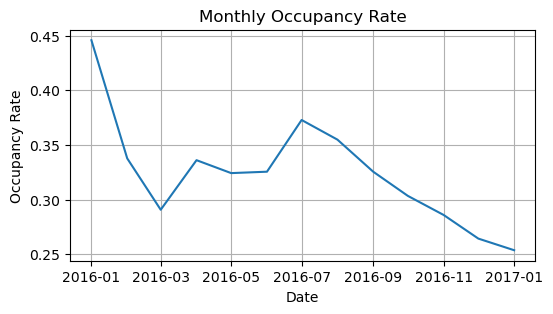

In [11]:
# Calculate monthly occupancy rate
occupancy_rate = (
    calendar_cleaned.groupby(["year", "month", "listing_id"])["available"]
    .mean()
    .reset_index()
)
occupancy_rate["occupancy_rate"] = 1 - occupancy_rate["available"]
occupancy_rate = occupancy_rate.drop("available", axis=1)
monthly_occupancy = (
    occupancy_rate.groupby(["year", "month"])["occupancy_rate"]
    .mean()
    .reset_index()
)

# Create a date column from the year and month
monthly_occupancy["date"] = pd.to_datetime(
    monthly_occupancy[["year", "month"]].assign(day=1)
)

# Graph monthly occupancy rate
plt.figure(figsize=(6, 3))
sns.lineplot(data=monthly_occupancy, x="date", y="occupancy_rate")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.title("Monthly Occupancy Rate")
plt.grid(True)
plt.show()

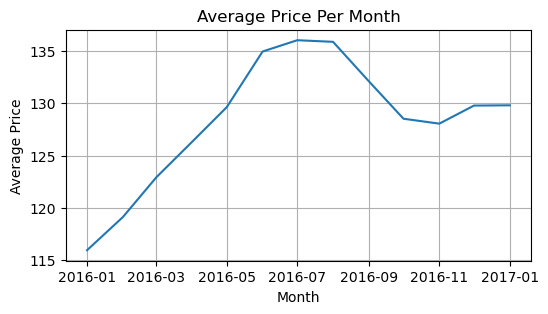

In [12]:
# Calculate monthly average price
avg_price_per_month = (
    calendar_cleaned.groupby(["year", "month"])["price"].mean().reset_index()
)

# Create a date column from the year and month
avg_price_per_month["date"] = pd.to_datetime(
    avg_price_per_month[["year", "month"]].assign(day=1)
)

# Graph price trend
plt.figure(figsize=(6, 3))
sns.lineplot(data=avg_price_per_month, x="date", y="price")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.title("Average Price Per Month")
plt.grid(True)
plt.show()

### Listings Dataset

In [13]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [14]:
get_null_col(df_listings)

Number of columns with missing data: 46


,No. Nulls,Nulls [%]
license,3818,100.00
square_feet,3721,97.46
monthly_price,2301,60.27
security_deposit,1952,51.13
weekly_price,1809,47.38
notes,1606,42.06
neighborhood_overview,1032,27.03
cleaning_fee,1030,26.98
transit,934,24.46
host_about,859,22.50


In [15]:
listings_cleaned = drop_cols(df_listings)

Columns with more than 50% null values: 4
Drop columns: Index(['square_feet', 'monthly_price', 'security_deposit', 'license'], dtype='object')
Columns with a unique value: 10
Drop columns: ['scrape_id', 'last_scraped', 'experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'jurisdiction_names']
Duplicate column: 1
df cleaned: (3818, 77)


In [16]:
# Identify columns that contain "url" in their name
url_columns = [col for col in listings_cleaned.columns if "url" in col.lower()]

print("Columnas con 'url' en su nombre:")
print(url_columns)

# Remove columns that contain "url" in their name
listings_cleaned = listings_cleaned.drop(columns=url_columns)
print(listings_cleaned.shape)

Columnas con 'url' en su nombre:
['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']
(3818, 69)


In [17]:
# Remove the '$' symbol and format the columns as float
for col in ["price", "weekly_price", "cleaning_fee", "extra_people"]:
    listings_cleaned[col] = (
        listings_cleaned[col]
        .astype(str)
        .str.replace("$", "")
        .str.replace(",", "")
        .astype("float32")
    )

In [18]:
# Transform the date related columns
for col in ["host_since", "first_review", "last_review"]:
    listings_cleaned[col] = pd.to_datetime(
        listings_cleaned[col], errors="coerce"
    )

In [19]:
# Check remaining columns
# print("Columns remaining after removing null values:")
# print(listings_cleaned.columns)

In [20]:
num_col = ['id', 'host_id', 'host_listings_count', 'zipcode', 
           'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
           'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 
           'number_of_reviews',  'review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month']

cat_col = []

bool_col = []

In [21]:
# get_null_col(listings_cleaned)

### Reviews Dataset

In [22]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [23]:
get_null_col(df_reviews)

Number of columns with missing data: 1


,No. Nulls,Nulls [%]
comments,18,0.02


In [24]:
df_reviews.dropna(subset=['comments'], axis=0, inplace=True)
get_null_col(df_reviews)
df_reviews.shape

No missing data


(84831, 6)

In [25]:
# Convert date column to datetime type
df_reviews['date'] = pd.to_datetime(df_reviews['date'])


In [26]:
df_reviews['comments'] = df_reviews['comments'].apply(clean_text)

In [27]:
reviews_cleaned = drop_cols(df_reviews)

Columns with more than 50% null values: 0
Columns with a unique value: 0
Duplicate column: 0
df cleaned: (84831, 6)


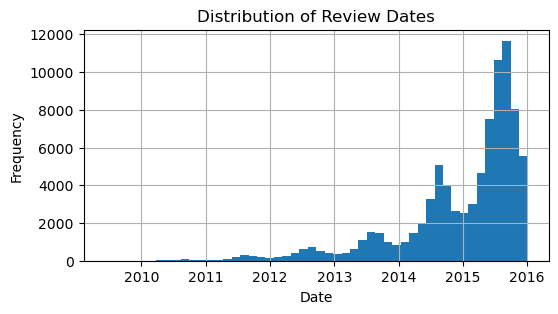

In [28]:
# Date distribution of reviews
plt.figure(figsize=(6, 3))
reviews_cleaned['date'].hist(bins=50)
plt.title('Distribution of Review Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

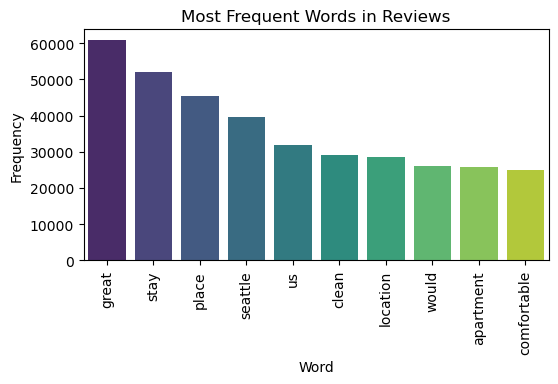

In [29]:
# Analysis of the most frequent words in the reviews
# Join all comments
all_comments = ' '.join(reviews_cleaned['comments'].tolist())

# Count the most frequent words
word_counts = Counter(all_comments.split())
common_words = word_counts.most_common(10)

# Display the most frequent words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(6, 3))
sns.barplot(x='Word', y='Frequency', data=common_words_df, palette="viridis")
plt.title('Most Frequent Words in Reviews')
plt.xticks(rotation=90)
plt.show()

In [30]:
# Apply sentiment analysis
reviews_cleaned["sentiment_vader"] = reviews_cleaned["comments"].apply(
    get_sentiment_vader
)

# Categorize feelings as positive, negative or neutral
reviews_cleaned["sentiment_category_vader"] = reviews_cleaned[
    "sentiment_vader"
].apply(
    lambda score: "positive"
    if score > 0
    else ("negative" if score < 0 else "neutral")
)

In [31]:
# Count feelings using VADER
sentiment_counts_vader = reviews_cleaned[
    "sentiment_category_vader"
].value_counts()

# Calculate the proportion of each sentiment category
sentiment_proportions_vader = (
    sentiment_counts_vader / len(reviews_cleaned)
) * 100

reviews_cleaned.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment_vader,sentiment_category_vader
0,7202016,38917982,2015-07-19,28943674,Bianca,cute cozy place perfect location everything,0.77,positive
1,7202016,39087409,2015-07-20,32440555,Frank,kelly great room central location beautiful bu...,0.99,positive


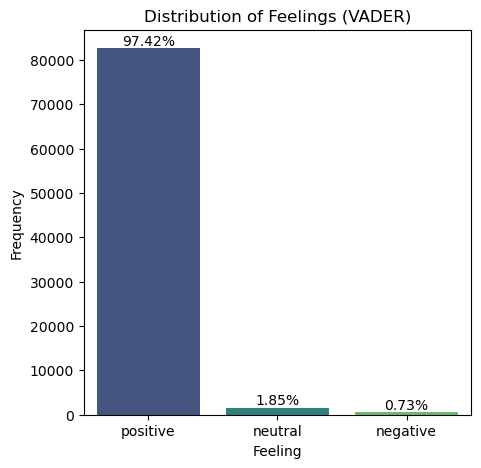

In [32]:
# Graph the distribution of feelings
plt.figure(figsize=(5, 5))
sns.barplot(
    x=sentiment_counts_vader.index,
    y=sentiment_counts_vader.values,
    palette="viridis",
)

# Add proportion labels to each bar
for i, proportion in enumerate(sentiment_proportions_vader):
    plt.text(
        i,
        sentiment_counts_vader.values[i],
        f"{proportion:.2f}%",
        ha="center",
        va="bottom",
    )

plt.title("Distribution of Feelings (VADER)")
plt.xlabel("Feeling")
plt.ylabel("Frequency")
plt.show()

In [33]:
feeling_comments(reviews_cleaned, "positive", 2)

Random comments with positive sentiment:
* alaska cruise little bit tired wanted stay house preparing next schedulecanada travel house cozy clean owner trusted friends house family stayed like real housethanks
* great place stay seattle quiet area close nice place park restaurant bars shop capitol hill ians place confortable really clean spent wonderful week hope come back soon thanks ian highly recommended


In [34]:
feeling_comments(reviews_cleaned, "negative", 2)

Random comments with negative sentiment:
* hosts nice helpful problem terrible odor apparent entered apartment finally determined probably new sisal rug installed read glue often cause odor offensive didnt anywhere else go opened windows stuck apartment dark even hard put makeup bathroom shame could cute place lightened odor problem cleared
* wir waren mit 6 personen unterwegs und dafür war das apartment genau richtig unsere beiden kleineren kinder haben im wohnzimmer auf der couch geschlafen gut ging bäder und küche waren voll funktionsfähig und sehr gutem zustand nur die frontplatte vom geschirrspüler hat gefehlt die lage des apartments war sehr gut knapp 10 minuten zur space needle und zum pike place market zu fuss auch den rest von downtown sind wir zu fuss abgegangen


In [35]:
feeling_comments(reviews_cleaned, "neutral", 2)

Random comments with neutral sentiment:
* jenns place terrificthe view location surpassed everything needed
* space email hiddenean similar pictures location close everything wanting judy quick respond questions made getting space fast simple
